In [2]:
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

def load_and_concat_datasets(parent_folder, channels):
    datasets = [
        xr.open_dataset(f'{parent_folder}/{channel}')[channel.split('.')[0]]
        for channel in channels
    ]
    ds_combined = xr.concat(datasets, dim='channels')
    return ds_combined

def find_min_max_across_channels(ds_combined):
    mins = [np.nanmin(ds_combined[i].values) for i in range(ds_combined.shape[0])]
    maxs = [np.nanmax(ds_combined[i].values) for i in range(ds_combined.shape[0])]
    return np.nanmin(mins), np.nanmax(maxs)

def rescale_data(data, global_min, global_max):
    return 255 * (data - global_min) / (global_max - global_min)

def get_combined_labels(cloud, clear, ice):
    labels = np.zeros(cloud.shape[0], dtype=int)
    labels[cloud == 1] = 0  # 0 represents cloud
    labels[clear == 1] = 1  # 1 represents clear
    labels[ice == 1] = 2    # 2 represents ice
    return labels

def perform_kmeans_and_evaluation(channels, parent_folder):
    ds_combined = load_and_concat_datasets(parent_folder, channels)

    global_min, global_max = find_min_max_across_channels(ds_combined)

    rescaled_data = xr.apply_ufunc(
        rescale_data,
        ds_combined,
        kwargs={'global_min': global_min, 'global_max': global_max},
        vectorize=True
    )

    n_samples = rescaled_data.shape[1] * rescaled_data.shape[2]
    n_features = rescaled_data.shape[0]
    rescaled_array = rescaled_data.values.reshape(n_samples, n_features)

    nan_mask = np.isnan(rescaled_array)
    rescaled_array_clean = rescaled_array[~nan_mask.any(axis=1)]

    n_clusters = 3
    kmeans = KMeans(n_clusters=n_clusters).fit(rescaled_array_clean)
    cluster_labels_clean = np.full(n_samples, np.nan)
    cluster_labels_clean[~nan_mask.any(axis=1)] = kmeans.labels_

    cloud_labels = xr.open_dataset(f'{parent_folder}/cloud_labels.nc')['Cloud']
    clear_labels = xr.open_dataset(f'{parent_folder}/clear_labels.nc')['Clear']
    ice_labels = xr.open_dataset(f'{parent_folder}/ice_labels.nc')['Ice']

    for label in [cloud_labels, clear_labels, ice_labels]:
        assert ds_combined.coords == label.coords, 'Mismatch between data coordinates and label coordinates'

    cloud_labels_clean = cloud_labels.values.flatten()
    clear_labels_clean = clear_labels.values.flatten()
    ice_labels_clean = ice_labels.values.flatten()

    labels_common_mask = ~np.isnan(cluster_labels_clean) & \
                         ~np.isnan(cloud_labels_clean) & \
                         ~np.isnan(clear_labels_clean) & \
                         ~np.isnan(ice_labels_clean)

    combined_labels_clean = get_combined_labels(cloud_labels_clean, clear_labels_clean, ice_labels_clean)
    combined_labels_clean_filtered = combined_labels_clean[labels_common_mask]
    cluster_labels_clean_filtered = cluster_labels_clean[labels_common_mask]

    conf_matrix = confusion_matrix(combined_labels_clean_filtered, cluster_labels_clean_filtered)
    accuracy = accuracy_score(combined_labels_clean_filtered, cluster_labels_clean_filtered)

    display_results(conf_matrix, accuracy, 'Combined')
    
    return ds_combined, cluster_labels_clean.reshape(ds_combined.shape[1:]), cloud_labels, clear_labels, ice_labels, kmeans, rescaled_array_clean

def display_results(matrix, accuracy, label_name):
    df = pd.DataFrame(matrix, 
                      columns=[f"Predicted {i}" for i in range(matrix.shape[1])], 
                      index=[f"Actual {i}" for i in range(matrix.shape[0])])
    print(f"Confusion Matrix - {label_name} Labels:")
    print(df)
    print(f"Accuracy - {label_name} Labels:", accuracy)
    print("\n" + "="*50 + "\n")

channels_radiance = ['S1_radiance_in.nc', 'S2_radiance_in.nc', 'S3_radiance_in.nc', 'S4_radiance_in.nc', 'S5_radiance_in.nc', 'S6_radiance_in.nc']
channels_thermal = ['S7_BT_in.nc', 'S8_BT_in.nc', 'S9_BT_in.nc']
channels = channels_radiance + channels_thermal

ds_combined, cluster_labels_clean, combined_labels, _, _, kmeans, rescaled_array_clean = perform_kmeans_and_evaluation(channels, '/Users/rashmilsinha/Downloads/Sentinel-lite/sentinel/')

/Users/rashmilsinha/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Confusion Matrix - Combined Labels:
          Predicted 0  Predicted 1  Predicted 2
Actual 0       839949       600995       334432
Actual 1            0          309           11
Actual 2            0         1813          882
Accuracy - Combined Labels: 0.4729781021159014




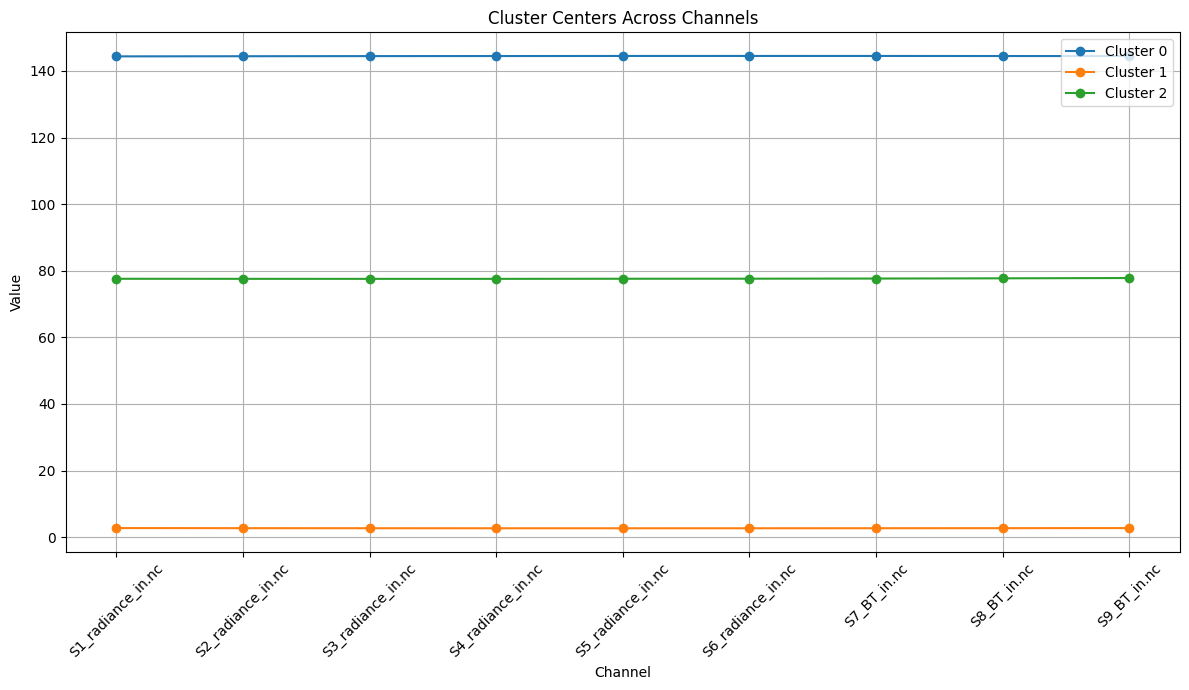

In [3]:
def plot_cluster_centers(kmeans):
    centers = kmeans.cluster_centers_

    plt.figure(figsize=(12, 7))
    for i, center in enumerate(centers):
        plt.plot(center, label=f"Cluster {i}", marker='o')
        
    plt.title("Cluster Centers Across Channels")
    plt.xlabel("Channel")
    plt.ylabel("Value")
    plt.xticks(ticks=np.arange(len(channels)), labels=channels, rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_cluster_centers(kmeans)


In [4]:
def determine_optimal_clusters(rescaled_array_clean):
    inertias = []
    cluster_range = range(1, 11) 
    for n_clusters in cluster_range:
        kmeans_temp = KMeans(n_clusters=n_clusters)
        kmeans_temp.fit(rescaled_array_clean)
        inertias.append(kmeans_temp.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(cluster_range, inertias, 'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal Cluster Number')
    plt.show()

determine_optimal_clusters(rescaled_array_clean)


/Users/rashmilsinha/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/rashmilsinha/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/rashmilsinha/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/rashmilsinha/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni